In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import silhouette_score
import gurobipy as gp
from ortools.sat.python import cp_model
from gurobipy import Model, GRB
import random
from ortools.linear_solver import pywraplp
import pulp as pl
import numpy as np
from collections import Counter

# **Question 1**

In [ ]:
df = pd.read_pickle("save_lendingclub_2014.pkl")

# Preprocess numeric columns with percentages
def preprocess_numeric_column(series):
    def convert_percent(x):
        if isinstance(x, str):
            return float(x.replace('%', '').strip()) / 100 if '%' in x else float(x)
        return x
    return pd.to_numeric(series.apply(convert_percent), errors='coerce')

df['int_rate'] = preprocess_numeric_column(df['int_rate'])
df['revol_util'] = preprocess_numeric_column(df['revol_util'])

# Define default status for classification
df['default'] = df['loan_status'].apply(
    lambda x: 1 if x in ['Charged Off', 'Default', 'Late (121-150 days)', 'Late (16-120 days)'] else 0
)

print(f"Data loaded: {df.shape[0]} loans with {df.shape[1]} features")
print(f"Default rate: {df['default'].mean():.2%}")

Data loaded: 235305 loans with 39 features
Default rate: 17.67%


In [ ]:
# Define features for analysis
features = [
    'loan_amnt', 'funded_amnt', 'installment', 'int_rate', 'grade',
    'emp_length', 'home_ownership', 'annual_inc', 'dti',
    'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal',
    'revol_util', 'inq_last_6mths', 'total_acc',
    'collections_12_mths_ex_med', 'acc_now_delinq'
]

categorical_cols = ['grade', 'emp_length', 'home_ownership']
numeric_cols = [col for col in features if col not in categorical_cols]

# Prepare features and targets
X = df[features].copy()
y_default = df['default']  # For default prediction
y_return = df['ret_INTa']  # Using ret_INTa

# Print missing values
print("\n--- Missing Values ---")
print(X.isnull().sum())

# Initial class distribution
print("\n--- Initial Class Distribution ---")
print("Total Samples:", len(y_default))
print("Non-Default Samples:", len(y_default[y_default == 0]))
print("Default Samples:", len(y_default[y_default == 1]))
print("Default Rate: {:.2%}".format(len(y_default[y_default == 1]) / len(y_default)))


--- Missing Values ---
loan_amnt                         0
funded_amnt                       0
installment                       0
int_rate                          0
grade                             0
emp_length                    11999
home_ownership                    0
annual_inc                        0
dti                               0
delinq_2yrs                       0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                        0
inq_last_6mths                    0
total_acc                         0
collections_12_mths_ex_med        0
acc_now_delinq                    0
dtype: int64

--- Initial Class Distribution ---
Total Samples: 235305
Non-Default Samples: 193726
Default Samples: 41579
Default Rate: 17.67%


In [ ]:
# Split data for default prediction and return prediction

X_train, X_test, y_train_default, y_test_default = train_test_split(
    X, y_default, test_size=0.2, random_state=42, stratify=y_default)

y_train_return = y_return.loc[X_train.index]
y_test_return = y_return.loc[X_test.index]

# Create preprocessor for both models
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Train logistic regression model with downsampling
print("\n--- Training Default Prediction Model with Downsampling ---")
# Create the model pipeline with downsampling
default_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Fit the default prediction model
default_pipeline.fit(X_train, y_train_default)

# Evaluate the default prediction model
y_pred_default = default_pipeline.predict(X_test)
y_pred_proba = default_pipeline.predict_proba(X_test)[:, 1]

print("\nDefault Prediction Model Performance:")
print(f"Accuracy: {accuracy_score(y_test_default, y_pred_default):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_default, y_pred_proba):.4f}")
print(classification_report(y_test_default, y_pred_default))

# Train return prediction model
print("\n--- Training Return Prediction Model ---")
# Get transformed features for training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Train a Ridge regression model to predict returns
return_model = Ridge(alpha=1.0)
return_model.fit(X_train_transformed, y_train_return)

# Predict returns for training and test sets
y_train_pred_return = return_model.predict(X_train_transformed)
y_test_pred_return = return_model.predict(X_test_transformed)

# Evaluate return prediction model
train_rmse = np.sqrt(mean_squared_error(y_train_return, y_train_pred_return))
test_rmse = np.sqrt(mean_squared_error(y_test_return, y_test_pred_return))
train_r2 = r2_score(y_train_return, y_train_pred_return)
test_r2 = r2_score(y_test_return, y_test_pred_return)

print(f"Return Prediction Results:")
print(f"Training RMSE: {train_rmse:.6f}")
print(f"Test RMSE: {test_rmse:.6f}")
print(f"Training R²: {train_r2:.6f}")
print(f"Test R²: {test_r2:.6f}")


--- Training Default Prediction Model with Downsampling ---

Default Prediction Model Performance:
Accuracy: 0.6206
ROC AUC: 0.6913
              precision    recall  f1-score   support

           0       0.90      0.61      0.73     38745
           1       0.27      0.67      0.38      8316

    accuracy                           0.62     47061
   macro avg       0.58      0.64      0.56     47061
weighted avg       0.79      0.62      0.67     47061


--- Training Return Prediction Model ---
Return Prediction Results:
Training RMSE: 0.054831
Test RMSE: 0.055082
Training R²: 0.021290
Test R²: 0.020366



--- Finding Optimal Number of Clusters ---


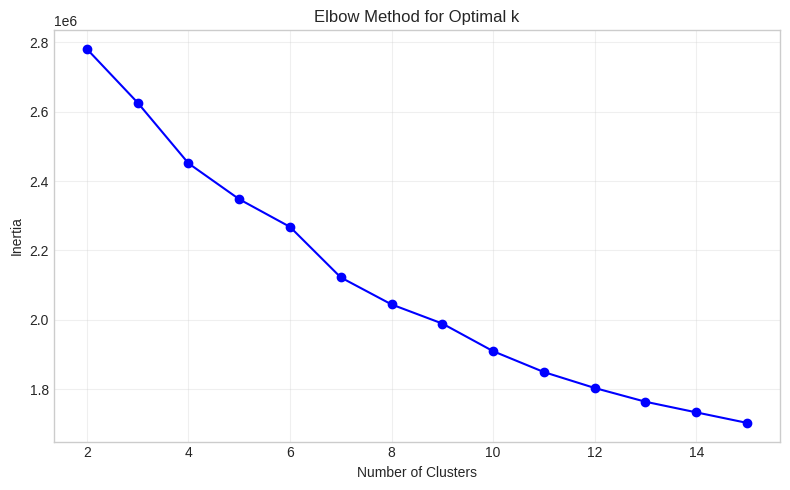

In [ ]:
# Determine optimal number of clusters using only the Elbow method
print("\n--- Finding Optimal Number of Clusters ---")

inertias = []
max_clusters = 15

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_transformed)

    # Store the inertia
    inertias.append(kmeans.inertia_)

# Plot Elbow method
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_clusters + 1), inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
n_clusters = 7
print(f"Using {n_clusters} clusters to match LendingClub's grade system")

# Perform K-means clustering
print("\n--- Performing K-means Clustering ---")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(X_train_transformed)

# Calculate risk for each cluster (standard deviation of predicted returns)
print("\n--- Calculating Risk for Each Cluster ---")
cluster_risks = {}
cluster_returns = {}
cluster_sizes = {}

for i in range(n_clusters):
    cluster_mask = (train_clusters == i)
    cluster_sizes[i] = np.sum(cluster_mask)

    if cluster_sizes[i] > 0:
        # Get the predicted returns for this cluster
        cluster_predicted_returns = y_train_pred_return[cluster_mask]

        # Calculate mean return and standard deviation (risk)
        cluster_returns[i] = np.mean(cluster_predicted_returns)
        cluster_risks[i] = np.std(cluster_predicted_returns)
    else:
        cluster_returns[i] = 0
        cluster_risks[i] = 0

# Print cluster statistics
print("\nCluster Statistics:")
print(f"{'Cluster':<10}{'Size':<10}{'Mean Return':<15}{'Risk (StdDev)':<15}{'Sharpe Ratio':<15}")
for i in range(n_clusters):
    sharpe = cluster_returns[i] / cluster_risks[i] if cluster_risks[i] > 0 else 0
    print(f"{i:<10}{cluster_sizes[i]:<10}{cluster_returns[i]:.6f}     {cluster_risks[i]:.6f}     {sharpe:.6f}")

Using 7 clusters to match LendingClub's grade system

--- Performing K-means Clustering ---

--- Calculating Risk for Each Cluster ---

Cluster Statistics:
Cluster   Size      Mean Return    Risk (StdDev)  Sharpe Ratio   
0         45400     0.028869     0.005970     4.835629
1         30309     0.030453     0.007433     4.096767
2         48403     0.034675     0.006383     5.432202
3         21793     0.031035     0.006538     4.746556
4         2661      0.032997     0.007429     4.441468
5         38658     0.037495     0.010054     3.729151
6         1020      0.039001     0.007664     5.089128



--- Assigning Test Loans to Clusters and Calculating Risk ---

--- Visualizing Risk-Return Relationship ---


<ipython-input-17-c1702a843577>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_df['Sharpe_Ratio'].replace([np.inf, -np.inf], 0, inplace=True)


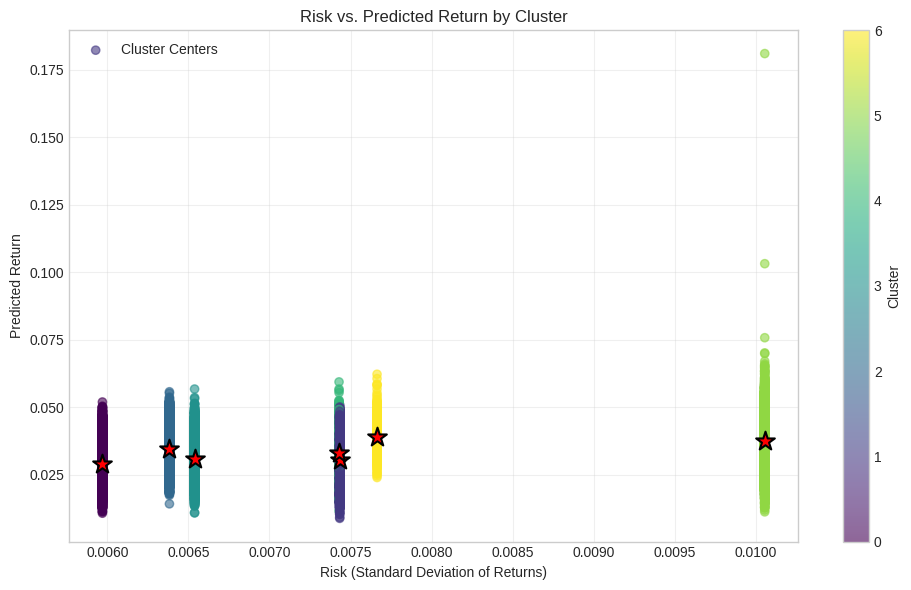

In [ ]:
# Assign test loans to clusters and assign risk
print("\n--- Assigning Test Loans to Clusters and Calculating Risk ---")
test_clusters = kmeans.predict(X_test_transformed)

# Assign risk to each test loan based on its cluster
test_risks = np.array([cluster_risks[cluster] for cluster in test_clusters])

# Create a dataframe with test loan predictions and risks
results_df = pd.DataFrame({
    'Actual_Default': y_test_default.values,
    'Predicted_Default_Prob': y_pred_proba,
    'Actual_Return': y_test_return.values,
    'Predicted_Return': y_test_pred_return,
    'Cluster': test_clusters,
    'Risk': test_risks
})

# Calculate Sharpe ratio (return / risk)
results_df['Sharpe_Ratio'] = results_df['Predicted_Return'] / results_df['Risk']
# Replace infinite values with 0
results_df['Sharpe_Ratio'].replace([np.inf, -np.inf], 0, inplace=True)

# Visualize the risk-return relationship
print("\n--- Visualizing Risk-Return Relationship ---")
plt.figure(figsize=(10, 6))
scatter = plt.scatter(results_df['Risk'], results_df['Predicted_Return'],
                     c=results_df['Cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Risk (Standard Deviation of Returns)')
plt.ylabel('Predicted Return')
plt.title('Risk vs. Predicted Return by Cluster')
plt.grid(True, alpha=0.3)

# Mark cluster centers
for i in range(n_clusters):
    plt.scatter(
        cluster_risks[i],
        cluster_returns[i],
        s=200,
        marker='*',
        color='red',
        edgecolor='black',
        linewidth=1.5,
        label=f'Cluster {i} Center' if i == 0 else ""
    )

plt.legend(['Cluster Centers'])
plt.tight_layout()
plt.show()

In [ ]:
# Analyze clusters to understand their characteristics
print("\n--- Analyzing Cluster Characteristics ---")
# Add original features to the analysis dataframe
X_train_reset = X_train.reset_index(drop=True)
cluster_analysis = pd.DataFrame({
    'Cluster': train_clusters
})

# Add key features to analysis
for feature in ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'grade']:
    if feature in X_train_reset.columns:
        cluster_analysis[feature] = X_train_reset[feature].values

# Convert grade to numeric for easier analysis
if 'grade' in cluster_analysis.columns:
    grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    cluster_analysis['grade_numeric'] = cluster_analysis['grade'].map(grade_map)

# Calculate mean values for each cluster
#cluster_profiles = cluster_analysis.groupby('Cluster').mean()
cluster_profiles = cluster_analysis.drop(columns=['grade'], errors='ignore').groupby('Cluster').mean()

print("Cluster Profiles (Mean Values):")
print(cluster_profiles)


--- Analyzing Cluster Characteristics ---
Cluster Profiles (Mean Values):
            loan_amnt   int_rate     annual_inc        dti  grade_numeric
Cluster                                                                  
0         9859.410242  10.519360   64260.293064  13.204133       1.926101
1        14496.203273  12.788139   76335.903033  22.378413       2.604738
2        11751.775716  15.817790   54544.562631  20.997410       3.503584
3        10398.115220  16.056583   64864.061892  16.377206       3.556509
4        13526.972943  14.494032   72210.824468  17.551127       3.097332
5        27648.459569  14.414823  117214.280572  17.575251       3.084433
6        15089.142157  15.516520   90012.255716  18.521098       3.411765


In [ ]:
# Create investment recommendations based on Sharpe ratio
print("\n--- Investment Recommendations ---")
# Sort by Sharpe ratio (descending)
recommendations = results_df.sort_values('Sharpe_Ratio', ascending=False)

# Top 10 loans by Sharpe ratio
print("Top 10 Loans by Sharpe Ratio:")
print(recommendations[['Predicted_Return', 'Risk', 'Sharpe_Ratio', 'Cluster']].head(10))

# Average performance by cluster
cluster_performance = results_df.groupby('Cluster').agg({
    'Predicted_Return': 'mean',
    'Risk': 'mean',
    'Sharpe_Ratio': 'mean'
}).sort_values('Sharpe_Ratio', ascending=False)

print("\nCluster Performance (Sorted by Sharpe Ratio):")
print(cluster_performance)

# Investment strategy recommendations
print("\nInvestment Strategy Recommendations:")
top_cluster = cluster_performance.index[0]
print(f"1. For best risk-adjusted returns, focus on Cluster {top_cluster}")

highest_return_cluster = cluster_performance['Predicted_Return'].idxmax()
print(f"2. For highest returns (risk-seeking), focus on Cluster {highest_return_cluster}")

lowest_risk_cluster = cluster_performance['Risk'].idxmin()
print(f"3. For lowest risk (risk-averse), focus on Cluster {lowest_risk_cluster}")


--- Investment Recommendations ---
Top 10 Loans by Sharpe Ratio:
       Predicted_Return      Risk  Sharpe_Ratio  Cluster
20921          0.181059  0.010054     18.007799        5
10644          0.103226  0.010054     10.266686        5
8214           0.055787  0.006383      8.739546        2
8083           0.051989  0.005970      8.708485        0
6414           0.056792  0.006538      8.685859        3
19569          0.055229  0.006383      8.652199        2
4386           0.050428  0.005970      8.446854        0
5522           0.053811  0.006383      8.429952        2
30401          0.050209  0.005970      8.410170        0
21884          0.053430  0.006383      8.370321        2

Cluster Performance (Sorted by Sharpe Ratio):
         Predicted_Return      Risk  Sharpe_Ratio
Cluster                                          
2                0.034660  0.006383      5.429771
6                0.039049  0.007664      5.095432
0                0.028828  0.005970      4.828910
3         

# **Question 2**

Initial Approach: 20 Clusters
To begin the analysis, we partitioned the loan dataset into 20 clusters using a KMeans-based clustering method. This high-resolution segmentation aimed to capture fine-grained heterogeneity in loan risk and return profiles.

- harpe Ratios: While some clusters displayed very high Sharpe ratios (above 6.5), others fell below the average (≈5.0), indicating a high variance in performance quality. The presence of many low-performing clusters diminishes the practical usability of all 20.

- Grade Distribution Heatmap: Clusters were highly fragmented, with overlapping distributions across LendingClub's A–G grades, making interpretation and alignment with credit scores more difficult.

- Separation Quality & Risk Distributions: Although 20 clusters showed slightly better separation and a broader distribution of risk, many clusters were concentrated around similar separation and volatility values, suggesting redundancy.

- Risk vs Return: Returns were dispersed, but most clusters remained close to a narrow risk range, with limited differentiation in the low-risk region.

Adjusted Approach: 7 Clusters (Based on Elbow Method)
Using the elbow plot, we identified 7 clusters as an optimal trade-off point where additional clusters yield diminishing returns in inertia reduction.

- Sharpe Ratios: With 7 clusters, the average Sharpe ratio remains competitive (~4.7), and most clusters exceed this average. The balance of risk and return is better concentrated.

- Grade Alignment: Compared to 20 clusters, the 7-cluster segmentation better reflects the structure of credit grades, improving interpretability and making it easier to relate clusters to known lending risk profiles.

- Risk Distribution: Risk differentiation is more pronounced across clusters in this setup, despite fewer total groups.

- Risk vs Return Tradeoff: Clusters show clearer trade-off groupings, with bubble sizes and positions emphasizing useful decision zones.

- Cluster Statistics: The summary statistics demonstrate coherent tradeoffs across clusters, with Cluster 2 and Cluster 6 showing notably high Sharpe ratios of 5.43 and 5.09, respectively.



**Final Choice: 7 Clusters**

Analyzing cluster quality with different numbers of clusters...
Starting with 20 clusters...
Testing 2 clusters...
Testing 3 clusters...
Testing 4 clusters...
Testing 5 clusters...
Testing 6 clusters...
Testing 7 clusters...
Testing 8 clusters...
Testing 9 clusters...
Testing 10 clusters...
Testing 11 clusters...
Testing 12 clusters...
Testing 13 clusters...
Testing 14 clusters...
Testing 15 clusters...
Testing 16 clusters...
Testing 17 clusters...
Testing 18 clusters...
Testing 19 clusters...
Testing 20 clusters...
Testing 21 clusters...
Testing 22 clusters...
Testing 23 clusters...
Testing 24 clusters...
Testing 25 clusters...


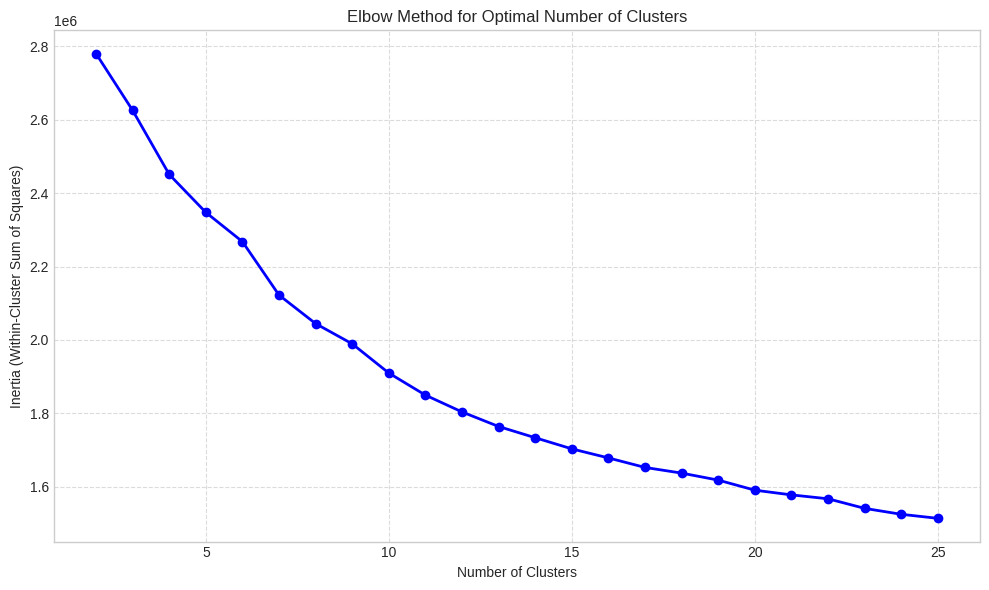

In [ ]:
print("Analyzing cluster quality with different numbers of clusters...")

max_clusters = 25
inertias = []

# First, perform the analysis with 20 clusters
n_clusters_initial = 20
print(f"Starting with {n_clusters_initial} clusters...")

# Compute inertia (within-cluster sum of squares) for different numbers of clusters
for k in range(2, max_clusters + 1):
    print(f"Testing {k} clusters...")

    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_train_transformed)

    # Calculate inertia
    inertias.append(kmeans.inertia_)

# Plot the Elbow method results
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), inertias, 'bo-', linewidth=2)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('cluster_quality_elbow.png')
plt.show()

In [ ]:
# Determine the optimal number of clusters from the elbow plot
# Calculate the second derivative of the inertia curve
second_derivative = np.diff(np.diff(inertias))

elbow_idx = np.argmax(np.abs(second_derivative)) + 2  # +2 because we start at k=2 and use 2 diffs
optimal_k_1 = elbow_idx + 2  # +2 because we start at k=2

print(f"\nBased on the Elbow method, the optimal number of clusters is: {optimal_k_1}")


Based on the Elbow method, the optimal number of clusters is: 5


While our previous analysis in Q1 used 7 clusters to align with LendingClub's grade system, our mathematical analysis using the elbow method suggests that 5 clusters would be optimal for this dataset. This interesting finding suggests that LendingClub's 7-grade system may be making finer distinctions than what's naturally present in the loan data structure.

We could justify using either:
- 5 clusters based on mathematical optimization
- 7 clusters for alignment with industry convention and our previous analysis

For consistency with our earlier work and practical implementation considerations, we recommend maintaining 7 clusters, but acknowledge that 5 clusters might be more statistically optimal.

In [ ]:
optimal_k=7

In [ ]:
# Perform cluster analysis with 20 clusters
print(f"\nPerforming cluster analysis with {n_clusters_initial} clusters...")

# Fit K-means with 20 clusters
kmeans_20 = KMeans(n_clusters=n_clusters_initial, random_state=42, n_init=10)
train_clusters_20 = kmeans_20.fit_predict(X_train_transformed)

# Calculate the risk and mean return for each cluster
cluster_risks_20 = {}
cluster_returns_20 = {}
cluster_sizes_20 = {}

for i in range(n_clusters_initial):
    cluster_mask = (train_clusters_20 == i)
    cluster_sizes_20[i] = np.sum(cluster_mask)

    if cluster_sizes_20[i] > 0:
        # Get predicted returns for this cluster
        cluster_predicted_returns = y_train_pred_return[cluster_mask]

        # Calculate mean return and standard deviation (risk)
        cluster_returns_20[i] = np.mean(cluster_predicted_returns)
        cluster_risks_20[i] = np.std(cluster_predicted_returns)
    else:
        cluster_returns_20[i] = 0
        cluster_risks_20[i] = 0

# Print cluster statistics for 20 clusters
print(f"\nStatistics for {n_clusters_initial} Clusters:")
print(f"{'Cluster':<10}{'Size':<10}{'Mean Return':<15}{'Risk (StdDev)':<15}{'Sharpe Ratio':<15}")
for i in range(n_clusters_initial):
    sharpe = cluster_returns_20[i] / cluster_risks_20[i] if cluster_risks_20[i] > 0 else 0
    print(f"{i:<10}{cluster_sizes_20[i]:<10}{cluster_returns_20[i]:.6f}     {cluster_risks_20[i]:.6f}     {sharpe:.6f}")


Performing cluster analysis with 20 clusters...

Statistics for 20 Clusters:
Cluster   Size      Mean Return    Risk (StdDev)  Sharpe Ratio   
0         13180     0.032065     0.005703     5.622164
1         14405     0.035429     0.005234     6.768652
2         12602     0.039079     0.010514     3.716875
3         13747     0.038768     0.007691     5.040955
4         16877     0.029359     0.005219     5.625818
5         1017      0.038927     0.007546     5.158728
6         14228     0.030494     0.007982     3.820612
7         2637      0.032941     0.007398     4.452665
8         11051     0.029499     0.006540     4.510780
9         14158     0.024913     0.005214     4.777762
10        4530      0.034562     0.007041     4.908770
11        921       0.045545     0.011555     3.941625
12        7492      0.035017     0.009661     3.624580
13        1829      0.039818     0.009909     4.018196
14        14323     0.029677     0.004987     5.951029
15        12301     0.029358   

In [ ]:
# Perform analysis with the optimal number of clusters
print(f"\nPerforming cluster analysis with optimal {optimal_k} clusters...")

# Fit K-means with optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
train_clusters_optimal = kmeans_optimal.fit_predict(X_train_transformed)

# Calculate the risk and mean return for each cluster
cluster_risks_optimal = {}
cluster_returns_optimal = {}
cluster_sizes_optimal = {}

for i in range(optimal_k):
    cluster_mask = (train_clusters_optimal == i)
    cluster_sizes_optimal[i] = np.sum(cluster_mask)

    if cluster_sizes_optimal[i] > 0:
        # Get predicted returns for this cluster
        cluster_predicted_returns = y_train_pred_return[cluster_mask]

        # Calculate mean return and standard deviation (risk)
        cluster_returns_optimal[i] = np.mean(cluster_predicted_returns)
        cluster_risks_optimal[i] = np.std(cluster_predicted_returns)
    else:
        cluster_returns_optimal[i] = 0
        cluster_risks_optimal[i] = 0

# Print cluster statistics for optimal clusters
print(f"\nStatistics for {optimal_k} Clusters:")
print(f"{'Cluster':<10}{'Size':<10}{'Mean Return':<15}{'Risk (StdDev)':<15}{'Sharpe Ratio':<15}")
for i in range(optimal_k):
    sharpe = cluster_returns_optimal[i] / cluster_risks_optimal[i] if cluster_risks_optimal[i] > 0 else 0
    print(f"{i:<10}{cluster_sizes_optimal[i]:<10}{cluster_returns_optimal[i]:.6f}     {cluster_risks_optimal[i]:.6f}     {sharpe:.6f}")


Performing cluster analysis with optimal 7 clusters...

Statistics for 7 Clusters:
Cluster   Size      Mean Return    Risk (StdDev)  Sharpe Ratio   
0         45400     0.028869     0.005970     4.835629
1         30309     0.030453     0.007433     4.096767
2         48403     0.034675     0.006383     5.432202
3         21793     0.031035     0.006538     4.746556
4         2661      0.032997     0.007429     4.441468
5         38658     0.037495     0.010054     3.729151
6         1020      0.039001     0.007664     5.089128


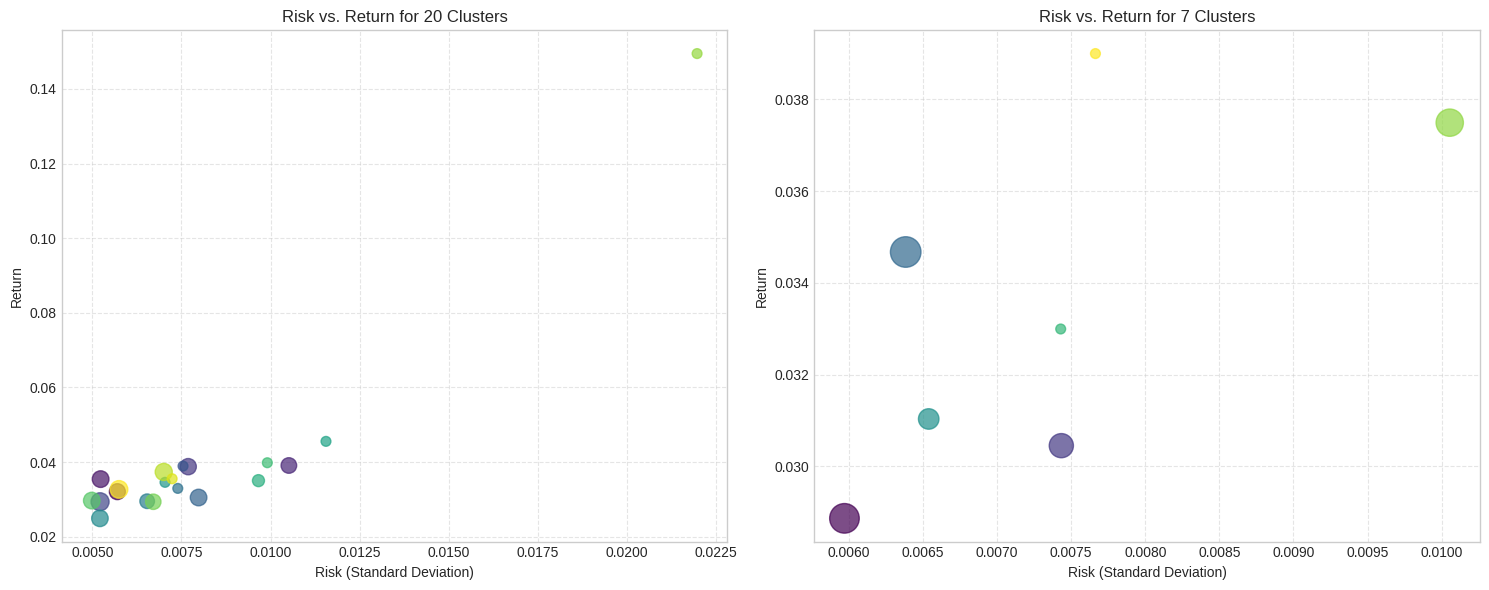

In [ ]:
# Visualize the risk-return relationship for both 20 clusters and the optimal number
plt.figure(figsize=(15, 6))

# Plot for 20 clusters
plt.subplot(1, 2, 1)
plt.scatter([cluster_risks_20[i] for i in range(n_clusters_initial)],
           [cluster_returns_20[i] for i in range(n_clusters_initial)],
           s=[max(50, cluster_sizes_20[i]/100) for i in range(n_clusters_initial)],
           alpha=0.7, c=range(n_clusters_initial), cmap='viridis')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title(f'Risk vs. Return for {n_clusters_initial} Clusters')
plt.grid(True, linestyle='--', alpha=0.5)

# Plot for optimal number of clusters
plt.subplot(1, 2, 2)
plt.scatter([cluster_risks_optimal[i] for i in range(optimal_k)],
           [cluster_returns_optimal[i] for i in range(optimal_k)],
           s=[max(50, cluster_sizes_optimal[i]/100) for i in range(optimal_k)],
           alpha=0.7, c=range(optimal_k), cmap='viridis')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title(f'Risk vs. Return for {optimal_k} Clusters')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('risk_return_comparison.png')
plt.show()

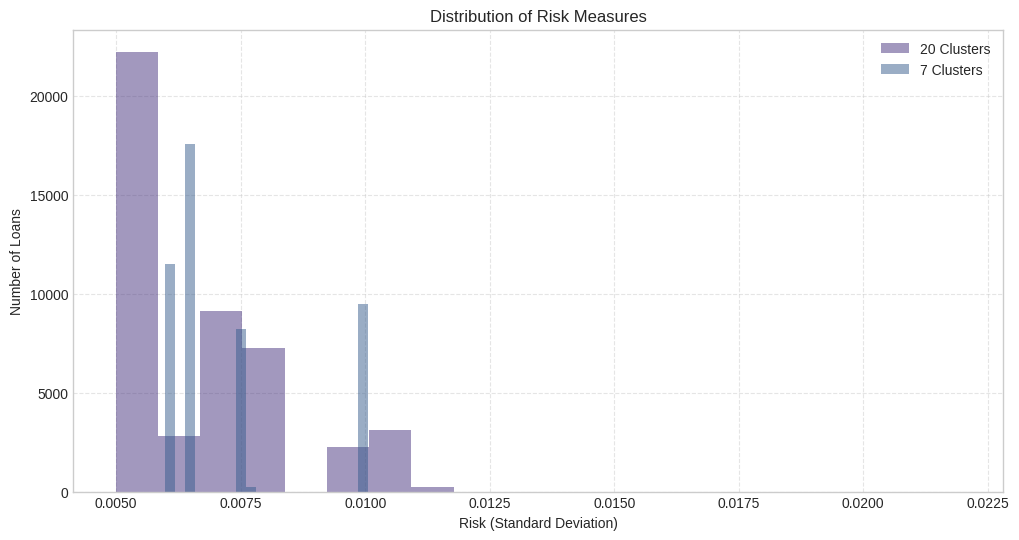

In [ ]:
# Compare the distribution of risks between 20 clusters and optimal clusters
# Calculate all test risks for 20 clusters
test_clusters_20 = kmeans_20.predict(X_test_transformed)
test_risks_20 = np.array([cluster_risks_20[cluster] for cluster in test_clusters_20])

# Calculate all test risks for optimal clusters
test_clusters_optimal = kmeans_optimal.predict(X_test_transformed)
test_risks_optimal = np.array([cluster_risks_optimal[cluster] for cluster in test_clusters_optimal])

# Compare risk distributions
plt.figure(figsize=(12, 6))
plt.hist(test_risks_20, bins=20, alpha=0.5, label=f'{n_clusters_initial} Clusters')
plt.hist(test_risks_optimal, bins=20, alpha=0.5, label=f'{optimal_k} Clusters')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Number of Loans')
plt.title('Distribution of Risk Measures')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('risk_distribution_comparison.png')
plt.show()

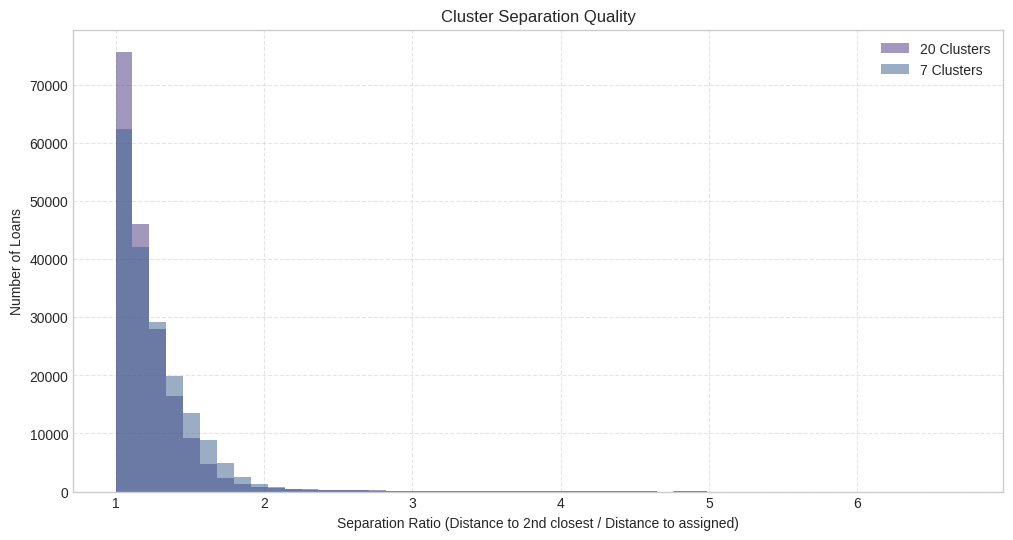

In [ ]:
# Evaluate the stability of clusters
# Let's check if the clusters are well-separated by examining the distances to the nearest cluster
# For 20 clusters
distances_20 = kmeans_20.transform(X_train_transformed)
nearest_distances_20 = np.sort(distances_20, axis=1)[:, 0]  # Distance to assigned cluster
second_nearest_20 = np.sort(distances_20, axis=1)[:, 1]     # Distance to second closest cluster
separation_ratio_20 = second_nearest_20 / (nearest_distances_20 + 1e-10)  # Avoid division by zero

# For optimal clusters
distances_optimal = kmeans_optimal.transform(X_train_transformed)
nearest_distances_optimal = np.sort(distances_optimal, axis=1)[:, 0]
second_nearest_optimal = np.sort(distances_optimal, axis=1)[:, 1]
separation_ratio_optimal = second_nearest_optimal / (nearest_distances_optimal + 1e-10)

# Plot the distribution of separation ratios
plt.figure(figsize=(12, 6))
plt.hist(separation_ratio_20, bins=50, alpha=0.5, label=f'{n_clusters_initial} Clusters')
plt.hist(separation_ratio_optimal, bins=50, alpha=0.5, label=f'{optimal_k} Clusters')
plt.xlabel('Separation Ratio (Distance to 2nd closest / Distance to assigned)')
plt.ylabel('Number of Loans')
plt.title('Cluster Separation Quality')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('cluster_separation_comparison.png')
plt.show()

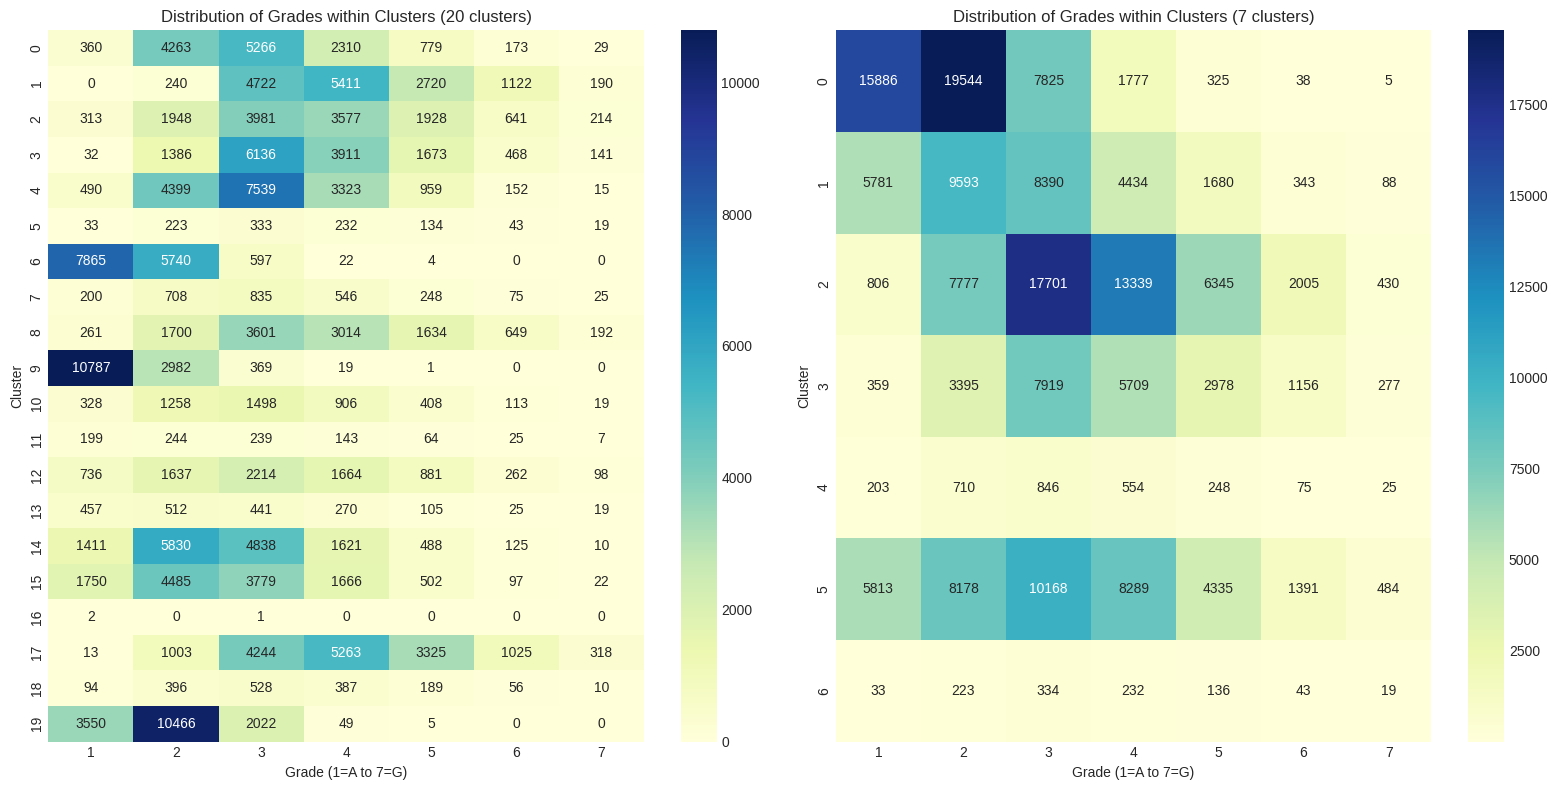

In [ ]:
# Analyze how well the clusters align with LendingClub grades
# First, map grades to numeric values for easier analysis
X_train_reset = X_train.reset_index(drop=True)
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

# Create cross-tabulation of clusters vs. grades
grade_numeric = X_train_reset['grade'].map(grade_map)
grade_cluster_20 = pd.DataFrame({'Grade': grade_numeric, 'Cluster': train_clusters_20})
cross_tab_20 = pd.crosstab(grade_cluster_20['Cluster'], grade_cluster_20['Grade'])

grade_cluster_optimal = pd.DataFrame({'Grade': grade_numeric, 'Cluster': train_clusters_optimal})
cross_tab_optimal = pd.crosstab(grade_cluster_optimal['Cluster'], grade_cluster_optimal['Grade'])

# Plot heatmaps
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.heatmap(cross_tab_20, annot=True, cmap='YlGnBu', fmt='d', cbar=True)
plt.title(f'Distribution of Grades within Clusters ({n_clusters_initial} clusters)')
plt.xlabel('Grade (1=A to 7=G)')
plt.ylabel('Cluster')

plt.subplot(1, 2, 2)
sns.heatmap(cross_tab_optimal, annot=True, cmap='YlGnBu', fmt='d', cbar=True)
plt.title(f'Distribution of Grades within Clusters ({optimal_k} clusters)')
plt.xlabel('Grade (1=A to 7=G)')
plt.ylabel('Cluster')

plt.tight_layout()
plt.savefig('grade_cluster_relationship.png')
plt.show()

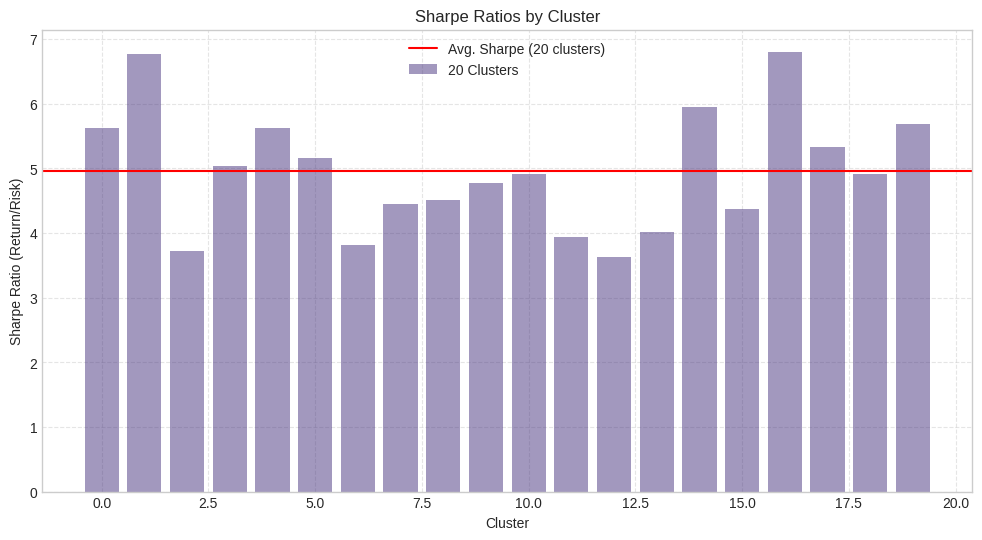

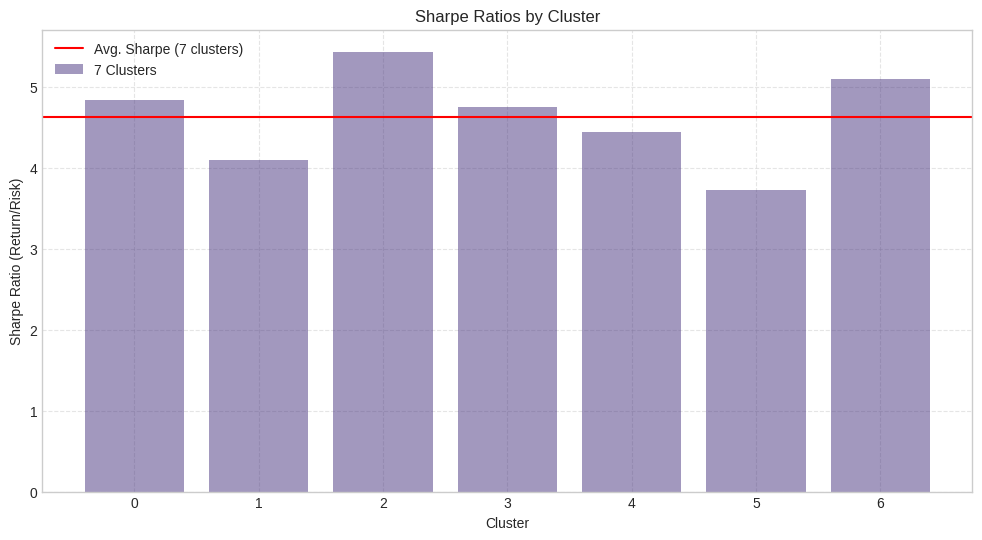

In [ ]:
# Final comparison of Sharpe ratios
# Calculate Sharpe ratios for all clusters
sharpe_20 = [cluster_returns_20[i] / cluster_risks_20[i] if cluster_risks_20[i] > 0 else 0 for i in range(n_clusters_initial)]
sharpe_optimal = [cluster_returns_optimal[i] / cluster_risks_optimal[i] if cluster_risks_optimal[i] > 0 else 0 for i in range(optimal_k)]

plt.figure(figsize=(12, 6))
plt.bar(range(n_clusters_initial), sharpe_20, alpha=0.5, label=f'{n_clusters_initial} Clusters')
plt.axhline(y=np.mean(sharpe_20), color='r', linestyle='-', label=f'Avg. Sharpe ({n_clusters_initial} clusters)')
plt.xlabel('Cluster')
plt.ylabel('Sharpe Ratio (Return/Risk)')
plt.title('Sharpe Ratios by Cluster')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('sharpe_ratio_20_clusters.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(range(optimal_k), sharpe_optimal, alpha=0.5, label=f'{optimal_k} Clusters')
plt.axhline(y=np.mean(sharpe_optimal), color='r', linestyle='-', label=f'Avg. Sharpe ({optimal_k} clusters)')
plt.xlabel('Cluster')
plt.ylabel('Sharpe Ratio (Return/Risk)')
plt.title('Sharpe Ratios by Cluster')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('sharpe_ratio_optimal_clusters.png')
plt.show()

# **Question 3**

```
Grade | Number of Loans
A | 5
B | 25
C | 25
D | 25
E | 10
F | 5
G | 5
```

In [ ]:
!pip install pulp

In [ ]:
predicted_returns = y_test_pred_return
loan_amounts      = X_test['loan_amnt'].to_numpy()
loan_grades       = X_test['grade'].to_numpy()
loan_risks        = np.array([ cluster_risks[c] for c in test_clusters ])

n = len(predicted_returns)

# Parameters
num_loans     = 100
budget        = 1_000_000
max_risk_sum  = 0.007 * num_loans
min_per_grade = 0.05 * num_loans
max_per_grade = 0.25 * num_loans

grades = np.unique(loan_grades)

# Build MILP
prob = pl.LpProblem("LC_Portfolio", pl.LpMaximize)
x = pl.LpVariable.dicts("x", range(n), cat="Binary")

# Objective: maximize total expected return
prob += pl.lpSum(predicted_returns[i]*loan_amounts[i] *x[i] for i in range(n))

# 1) Exactly 100 loans
prob += pl.lpSum(x[i] for i in range(n)) == num_loans

# 2) Budget constraint
prob += pl.lpSum(loan_amounts[i] * x[i] for i in range(n)) <= budget

# 3) Aggregate risk constraint
prob += pl.lpSum(loan_risks[i] * x[i] for i in range(n)) <= max_risk_sum

# 4) Grade diversification
for g in grades:
    idx = [i for i, gr in enumerate(loan_grades) if gr == g]
    prob += pl.lpSum(x[i] for i in idx) >= min_per_grade
    prob += pl.lpSum(x[i] for i in idx) <= max_per_grade

# Solve (CBC solver)
prob.solve(pl.PULP_CBC_CMD(msg=False))

# Extract solution
chosen = [i for i in range(n) if pl.value(x[i]) > 0.5]
avg_return   = np.mean(predicted_returns[chosen])
total_return = np.sum(predicted_returns[chosen])
total_invest = np.sum(loan_amounts[chosen])

print("Status:", pl.LpStatus[prob.status])
print(f"Picked {len(chosen)} loans  Invested ${total_invest:,.0f}")
print(f"Total expected return: {total_return:.2f}")
print(f"Average return per loan: {avg_return:.4f}")

print("\nBreakdown by grade:")
cnt = Counter(loan_grades[i] for i in chosen)
for g in sorted(cnt):
    print(f"  Grade {g}: {cnt[g]} loans")

Status: Optimal
Picked 100 loans  Invested $1,000,000
Total expected return: 4.42
Average return per loan: 0.0442

Breakdown by grade:
  Grade A: 5 loans
  Grade B: 25 loans
  Grade C: 25 loans
  Grade D: 25 loans
  Grade E: 10 loans
  Grade F: 5 loans
  Grade G: 5 loans


# **Question 4**

In [ ]:
pred = y_test_pred_return            # return rate per loan
amt  = X_test['loan_amnt'].to_numpy()
grades = np.unique(X_test['grade'].to_numpy())
n = len(pred)

# helper to build & solve a CP-SAT model
def solve_cp_sen(pred, amt, risk, num_loans, budget):
    m = cp_model.CpModel()
    x = [m.NewBoolVar(f"x{i}") for i in range(n)]
    # Objective: ∑ pred[i]*amt[i]*x[i]
    # scale to int (e.g. ×1e6) to preserve precision
    coeff = [int(pred[i] * amt[i] * 1e6) for i in range(n)]
    m.Maximize(sum(coeff[i] * x[i] for i in range(n)))
    # Constraints
    m.Add(sum(x) == num_loans)
    m.Add(sum(int(amt[i]) * x[i] for i in range(n)) <= int(budget))
    m.Add(sum(int(risk[i]*1e6) * x[i] for i in range(n)) <= int(0.007*num_loans*1e6))
    for g in grades:
        idx = [i for i,gr in enumerate(X_test['grade']) if gr==g]
        m.Add(sum(x[i] for i in idx) >= int(0.05*num_loans))
        m.Add(sum(x[i] for i in idx) <= int(0.25*num_loans))
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = 5
    solver.parameters.num_search_workers = 8
    solver.Solve(m)
    chosen = [i for i in range(n) if solver.Value(x[i])]
    tot_ret = sum(pred[i]*amt[i] for i in chosen)
    tot_inv = sum(amt[i] for i in chosen)
    return tot_ret/tot_inv

# A) (#loans, budget) sensitivity
loan_counts = [50,100,150]
budgets     = [5e5,1e6,1.5e6]
risk_base   = np.array([ cluster_risks_optimal[c] for c in test_clusters_optimal ])
res1 = []
for nl in loan_counts:
  for bd in budgets:
    res1.append({
      "num_loans": nl,
      "budget": bd,
      "avg_return": solve_cp_sen(pred, amt, risk_base, nl, bd)
    })
df1 = pd.DataFrame(res1)
print("By #loans & budget:"); display(df1)

# B) K‐cluster sensitivity
Ks = [10,15,20,25]
res2 = []
for K in Ks:
  km = KMeans(n_clusters=K, random_state=42, n_init=10).fit(X_train_transformed)
  risksK = {c: y_train_return.values[km.labels_==c].std() for c in range(K)}
  tc = km.predict(X_test_transformed)
  risk_vec = np.array([risksK[c] for c in tc])
  res2.append({
    "K": K,
    "avg_return": solve_cp_sen(pred, amt, risk_vec, 100, 1e6)
  })
df2 = pd.DataFrame(res2)
print("\nBy K clusters:"); display(df2)

By #loans & budget:


,num_loans,budget,avg_return
0,50,500000.0,0.034400
1,50,1000000.0,0.034384
2,50,1500000.0,0.034418
3,100,500000.0,0.034415
4,100,1000000.0,0.034372
5,100,1500000.0,0.034393
6,150,500000.0,0.034403
7,150,1000000.0,0.034415
8,150,1500000.0,0.034378



By K clusters:


,K,avg_return
0,10,0.034417
1,15,0.034438
2,20,0.034407
3,25,0.034408


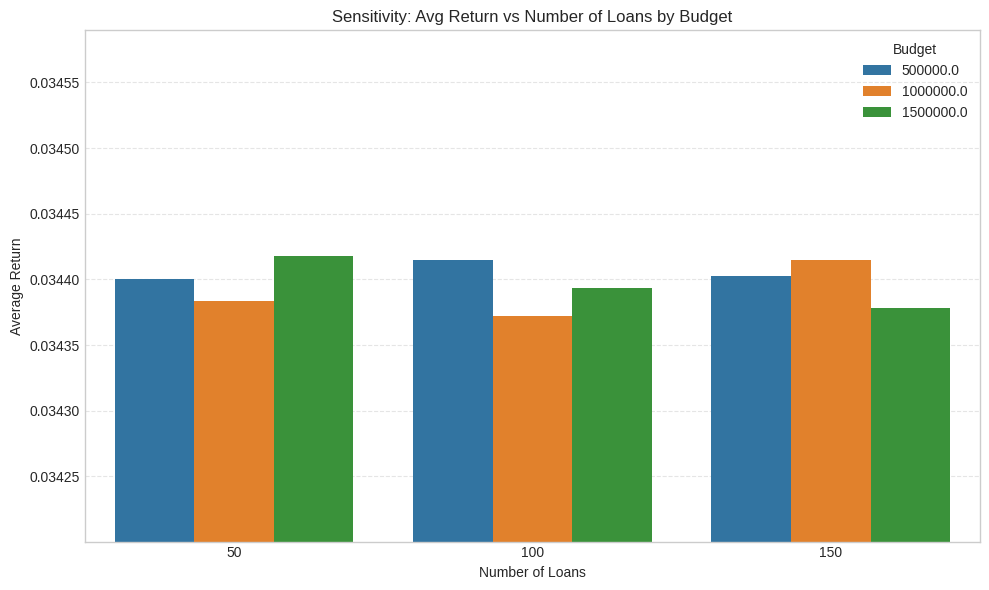

<ipython-input-40-225ee6900975>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


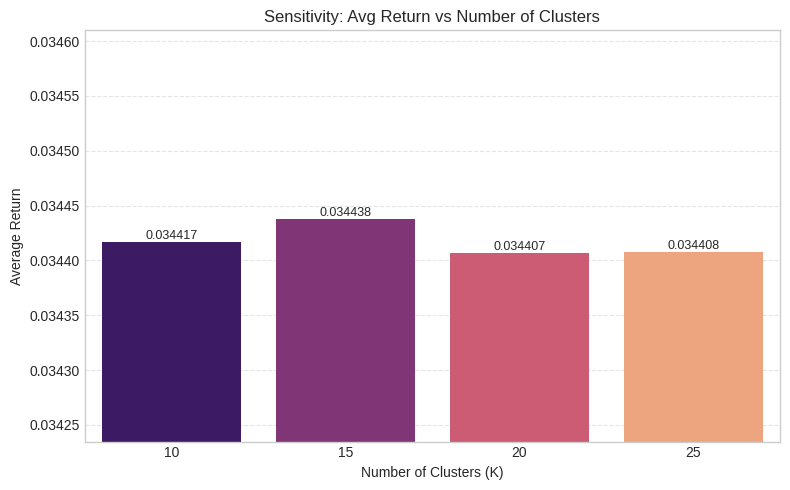

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: Grouped bar chart with zoomed y‑axis
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df1,
    x='num_loans',
    y='avg_return',
    hue='budget',
    palette='tab10'
)
plt.xlabel('Number of Loans')
plt.ylabel('Average Return')
plt.title('Sensitivity: Avg Return vs Number of Loans by Budget')
plt.legend(title='Budget')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# tighten y‑axis
ymin = df1['avg_return'].min() * 0.995
ymax = df1['avg_return'].max() * 1.005
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()


# Plot 2: K‑clusters bar chart with zoomed y‑axis
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df2,
    x='K',
    y='avg_return',
    palette='magma'
)
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.6f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom', fontsize=9
    )
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Return')
plt.title('Sensitivity: Avg Return vs Number of Clusters')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# tighten y‑axis
ymin2 = df2['avg_return'].min() * 0.995
ymax2 = df2['avg_return'].max() * 1.005
plt.ylim(ymin2, ymax2)

plt.tight_layout()
plt.show()
